# **Методы выявления выбросов**

##### **МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА**
***
Это самый трудоёмкий метод, основанный на житейской логике, методе пристального взгляда и небольшом количестве статистики. Он предполагает поиск невозможных и нелогичных значений в данных.

In [2]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sber_data = pd.read_csv('data/sber_data.csv')
display(sber_data.head())
# столбцы, где доля пропусков больше 0
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,0,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,0,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,0,5700000
3,4,89,50.0,9.0,Mitino,6839.0,9,17063.0,10,0,...,0.934273,0.892674,0.236455,1.031777,1.561505,16.990677,16.041521,good,0,13100000
4,5,77,77.0,4.0,Basmannoe,3240.0,7,7770.0,9,0,...,0.077901,0.810801,0.376838,0.378756,0.121681,1.112486,1.800125,excellent,0,16331452


In [3]:
# принимаем признак, по которому мы будем искать выбросы,
# рассчитаем его статистические показатели
# (минимум, максимум, среднее, квантили) и по ним попробуем определить наличие аномалий

sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

Что нам говорит метод describe()? Во-первых, у нас есть квартиры с нулевой жилой площадью. Во-вторых, в то время как 75-й квантиль равен 43, максимум превышает 7 тысяч квадратных метров (целый дворец, а не квартира!).

In [4]:
# Найдём число квартир с нулевой жилой площадью:
print(sber_data[sber_data['life_sq'] == 0].shape[0])

45


Это могут быть апартаменты — вид коммерческой недвижимости, которая юридически не является жилой площадью, но законно продаётся по ценам, сопоставимым с квартирными. Оставим их в покое.

In [5]:
# А теперь выведем здания с жилой площадью более 7 000 квадратных метров:
display(sber_data[sber_data['life_sq'] > 1000])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


Вот он, красавец! Выброс налицо: гигантская жилая площадь (life_sq), да ещё почти в 100 раз превышает общую площадь (full_sq).
Логичен вопрос: а много ли у нас таких квартир, у которых жилая площадь больше, чем суммарная?

In [6]:
# выясняем сколько квартир-выбросов
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


Таких квартир оказывается 37 штук. Подобные наблюдения уже не поддаются здравому смыслу — они являются ошибочными, и от них стоит избавиться. Для этого можно воспользоваться методом drop() и удалить записи по их индексам:

In [7]:
# Удаляем выбросы, где жилплощадь больше общей площади
cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число записей: 30434


Ещё пример: давайте посмотрим на признак числа этажей (floor).

In [8]:
display(sber_data['floor'].describe())

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

Снова видим подозрительную максимальную отметку в 77 этажей. Проверим все квартиры, которые находятся выше 50 этажей:

In [9]:
display(sber_data[sber_data['floor']> 50])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


Всего одна квартира в Ломоносовском районе. Пора идти в интернет в поиске самых высоких зданий в Москве! 

Убеждаемся в том, что здания выше 70 этажей находятся на территории комплекса Москва-Сити (Пресненский район). В Ломоносовском районе таких жилых высоток нет. Получается, что данное наблюдение — выброс.

Мы заранее знали про апартаменты и о том, что не бывает квартир с жилой площадью, которая превышает общую. Кроме того, мы «нагуглили» информацию о московских высотках. Однако бывают данные, где необходимо углубиться в предметную область, чтобы понять, что наблюдения являются «сверхъестественными».

##### **МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)**
***
Отличным помощником в поиске потенциальных выбросов является **визуализация**. Если признак является числовым, то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.

На гистограмме мы можем увидеть потенциальные выбросы как низкие далеко отстоящие от основной группы столбцов «пеньки», а на коробчатой диаграмме — точки за пределами усов.

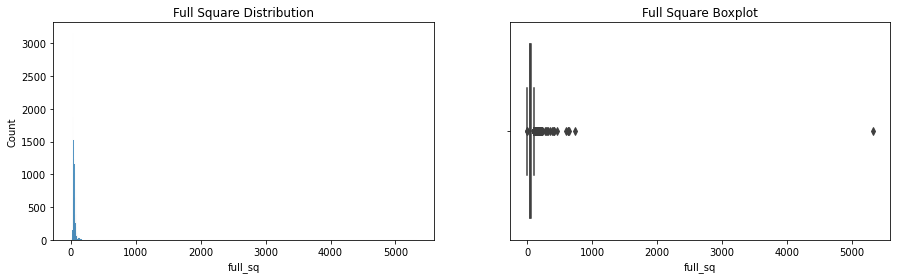

In [10]:
# Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

# Основная масса квартир имеет общую площадь менее 250 квадратных метров,
# и лишь несколько невзрачных наблюдений выбиваются из этого интервала.
# Максимальная площадь, судя по гистограмме, превышает 5 000 квадратных метров.

Гистограмма, реализованная в seaborn, автоматически выбирает число столбцов, необходимое для наилучшей визуализации распределения. Когда признак содержит выбивающиеся значения, число столбцов становится очень велико и в итоге получается такая «кракозябра». 

По этой же причине получается сплюснутая под весом выбросов коробчатая диаграмма. Она помогает более чётко увидеть потенциальные аномалии, которые находятся за пределами усов (1.5 межквартильных размаха).

Визуализация помогает определить наличие выбросов. Для того чтобы их найти, можно воспользоваться статистическими подходами. 

Одним из таких подходов является метод **межквартильного размаха** (его еще называют **методом Тьюки**), который используется для построения коробчатой диаграммы.

Алгоритм метода:

→ вычислить 25-ый и 75-ый квантили (первый и третий квартили) — *Q25* и *Q75* для признака, который мы исследуем;

→ вычислить межквартильное расстояние: *IQR=Q75-Q25*;

→ вычислить верхнюю и нижнюю границы Тьюки: 

*bound lower = Q25 - 1.5 * IQR*

*bound upper = Q75 - 1.5 * IQR*

→ найти наблюдения, которые выходят за пределы границ.

МЕТОД ТЬЮКИ (ФУНКЦИЯ):

**outliers_iqr(),**

которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.

Квантили вычисляются с помощью метода quantile(). Потенциальные выбросы определяются при помощи фильтрации данных по условию выхода за пределы верхней или нижней границы.

In [11]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [12]:
# Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


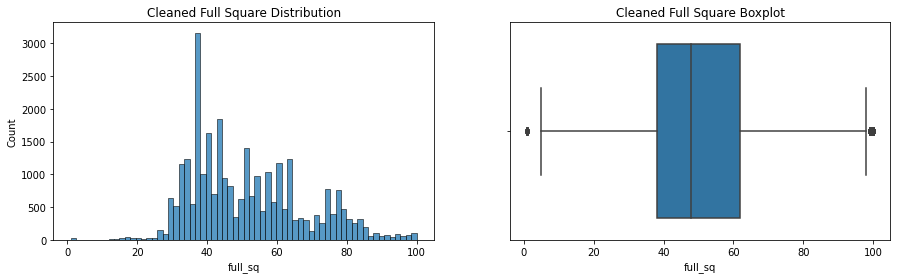

In [13]:
# Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned_sber_data:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

На первый взгляд — стерильно. Однако если присмотреться, то коробчатая диаграмма всё ещё продолжает говорить, что в данных есть одиночные выбросы с обеих сторон от границ. К тому же у нас сильно урезался диапазон жилой площади — максимальная площадь составляет около 100 кв. м. 

Как же так, **неужели метод не работает?**

Причина кроется в том, что после удаления выбросов квартили рассчитываются заново по новым данным, и так оказалось, что из-за свойств распределения были снова найдены точки, которые считаются выбросами.

Классический метод межквартильного размаха не учитывает особенностей распределения! Он **требует, чтобы данные были распределены плюс-минус нормально** (гистограмма должна быть похожа на колокол) и требует от распределения примерной симметричности (чтобы у гистограммы были одинаковые хвосты в обе стороны).

У нас же распределение (даже после отсечения выбросов) отличается от заявленных критериев. Оно несимметрично: правый хвост изначального распределения гораздо длиннее левого (для Москвы вполне естественны квартиры с площадью свыше 100 квадратных метров) и вовсе не колоколообразно. Попросту говоря, выбор метода поиска **не оправдал себя**.

In [14]:
# Давайте немного модифицируем нашу функцию outliers_iqr(). 
# Добавьте в нее параметры left и right, которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5).
# Функция, как и раньше должна возвращать потенциальные выбросы и очищенный DataFrame.

def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned    

outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq', 2, 2)
print('Outliers by Tukeys method: {}'.format(outliers.shape[0]))
print('The resulting number of records: {}'.format(cleaned.shape[0]))

Outliers by Tukeys method: 589
The resulting number of records: 29863


In [15]:
# Давайте ослабим границы метода Тьюки справа и усилим их влево.
# Примените модифицированную функцию outliers_iqr_mod() к признаку full_sq
# из таблицы sber_data данным с параметрами left=1 и right=6.
# Результаты работы поместите в переменные outliers и cleaned.
# Чему равно результирующее число выбросов в данных?

outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq', 1, 6)
print('Outliers by Tukeys method: {}'.format(outliers.shape[0]))
print('The resulting number of records: {}'.format(cleaned.shape[0]))

Outliers by Tukeys method: 59
The resulting number of records: 30403


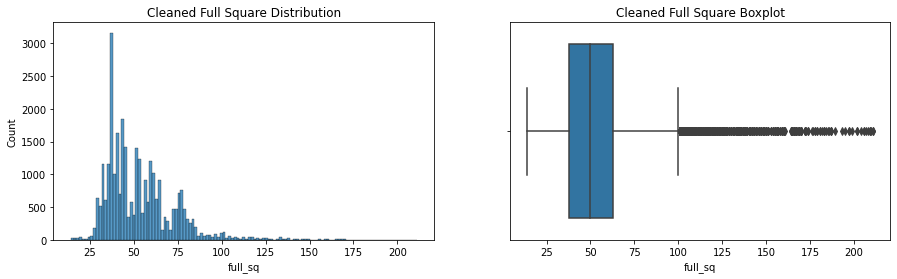

In [16]:
# Если мы построим гистограмму и коробчатую диаграмму на полученных данных, то увидим вот такую картинку:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

##### **МЕТОД Z-ОТКЛОНЕНИЙ (МЕТОД СИГМ)**
***
Последний метод, который мы рассмотрим, — это метод, основанный на **правиле трёх сигм для нормального распределения**.

***Правило трёх сигм гласит: если распределение данных является нормальным, то 99,73 % лежат в интервале от (мю - 3 х сигма, мю + 3 х сигма), где   (мю) — математическое ожидание (для выборки это среднее значение), а  (сигма) — стандартное отклонение. Наблюдения, которые лежат за пределами этого интервала, будут считаться выбросами.***

Схематично:

![Схема метода трёх сигм](https://lms.skillfactory.ru/assets/courseware/v1/721bbe7e904e9a3f3700f24a7dba48fd/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-unit-1-mod-14-25.png)

Что делать, если данные не распределены нормально?

На такой случай есть один трюк. Иногда для распределений, похожих на **логнормальное**, может помочь **логарифмирование**. Оно может привести исходное распределение к подобию нормального. Причем, основание логарифма может быть любым.

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.

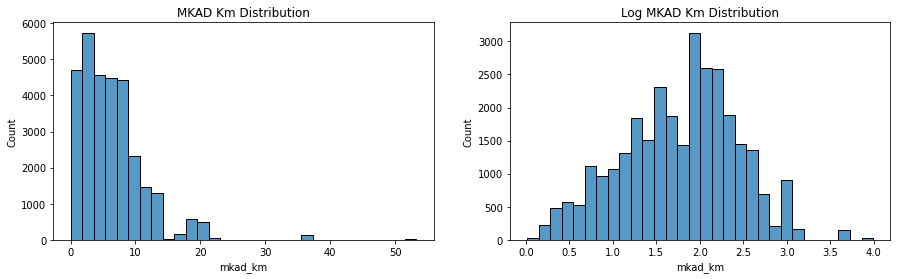

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

Левое распределение напоминает логнормальное распределение с наличием потенциальных выбросов-«пеньков», далеко отстоящих от основной массы наблюдений.

Взяв натуральный логарифм от левого распределения, мы получаем правое, которое напоминает слегка перекошенное нормальное. Слева от моды (самого высокого столбика) наблюдается чуть больше наблюдений, нежели справа. По-научному это будет звучать так: «распределение имеет **левостороннюю асимметрию»**.

In [19]:
# Численный показатель асимметрии можно вычислить с помощью метода .skew():
print(log_mkad_km.skew())

-0.14263612203024953


Асимметрия распределения называется правосторонней, если она положительная:

As > 0

Асимметрия распределения называется левосторонней, если она отрицательная:

As < 0

Давайте реализуем алгоритм метода z-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание *мю* (среднее) и стандартное отклонение *сигма* признака *х*;

→ вычислить нижнюю и верхнюю границу интервала как:

*bound lower = мю - 3 х сигма*

*bound upper =  мю + 3 х сигма*

→ найти наблюдения, которые выходят за пределы границ.

МЕТОД Z (ФУНКЦИЯ)

**outliers_z_score(),**

На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

Как и раньше, функция будет возвращать выбросы и очищенные от них данные:

In [20]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [21]:
# Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


In [22]:
# Узнаем, в каких районах (sub_area) представлены выбросовые квартиры:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


Наши потенциальные выбросы — это квартиры из поселений «Роговское» и «Киевский». Снова обращаемся к силе интернета и «пробиваем» наших подозреваемых. Эти поселения — самые удалённые районы Московской области; первое из них — это и вовсе граница с Калужской областью. 

И тут возникает закономерный вопрос: а стоит ли считать такие наблюдения за выбросы?

Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала *мю + 3 х сигма*. Вертикальные линии можно построить с помощью метода **axvline()**. Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

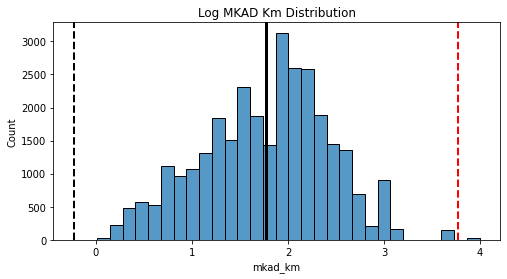

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=3)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='r', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

Итак, что мы графически построили интервал метода трёх сигм поверх нашего распределения. Он показывает, какие наблюдения мы берем в интервал, а какие считаем выбросами. Легко заметить, среднее значение (жирная вертикальная линия) находится левее моды, это свойство распределений с левосторонней асимметрией. Также видны наблюдения, которые мы не захватили своим интервалом (небольшой пенек правее верхней границы) — это и есть наши квартиры из из поселений "Роговское" и "Киевский". Очевидно, что если немного (меньше чем на одну сигму) "сдвинуть" верхнюю границу вправо, мы захватим эти наблюдения.

In [29]:
# Давайте расширим правило 3ех сигм, чтобы иметь возможность учитывать особенности данных.
# Добавьте в функцию outliers_z_score() параметры left и right, которые будут задавать число сигм (стандартных отклонений) 
# влево и вправо соответственно, которые определяют границы метода z-отклонения. 
# По умолчанию оба параметры равны 3

def outliers_z_score_mod(data, feature, log_scale=False, left=3,right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score_mod(sber_data, 'mkad_km', True, 3, 3.5)
print('Outliers by Z method: {}'.format(outliers.shape[0]))
print('The resulting number of records: {}'.format(cleaned.shape[0]))

Outliers by Z method: 0
The resulting number of records: 30471


Стоило нам немного увеличить правую границу метода z-отклонений, как мы получили отсутствие выбросов в признаке. Давать ли такие «послабления» или нет — это ваше решение и полностью зависит от специфики задачи, однако вы можете пользоваться этим трюком, чтобы более тщательно подходить к поиску аномалий.

**РЕЗЮМЕ ПО МЕТОДАМ ПОИСКА ВЫБРОСОВ**
***

Мы рассмотрели классические методы выявления аномальных данных. Как вы сами поняли, каждый из них имеет свои преимущества и недостатки.

Метод ручного поиска **тяжело автоматизировать**, однако вы сами организовываете проверки, следите за процессом отсеивания выбросов и руководствуетесь не только статистикой, но и здравым смыслом. К тому же из всех представленных только этот метод **способен выявить логические нестыковки в данных** (например, общая площадь меньше жилой или число этажей более 77 в районе, где нет таких зданий). Обычно этот метод используется в комплексе с другими, чтобы удостовериться в том, что найденные данные действительно являются выбросами, и произвести логическую очистку, на которую неспособны другие методы.

Методы межквартильного размаха и z-отклонений довольно **просты в реализации** и основаны на стройной математической теории, а не на эвристиках. Но это их преимущество и недостаток. Оба метода разработаны **для данных, распределённых приблизительно нормально**. Проблема в том, что далеко не всё в мире имеет нормальное распределение. Необходимо внимательно «рыться» в данных, совершать дополнительные преобразования, чтобы привести их хотя бы к подобию нормального распределения, либо подбирать границы методов, чтобы учитывать особенности распределений. В противном случае методы начинают считать выбросами всё, что не вписывается в жёсткие границы, и вы **рискуете лишиться важных данных**! Учитывайте это в своей работе и всегда проверяйте результаты.

##### **Задачи**
***

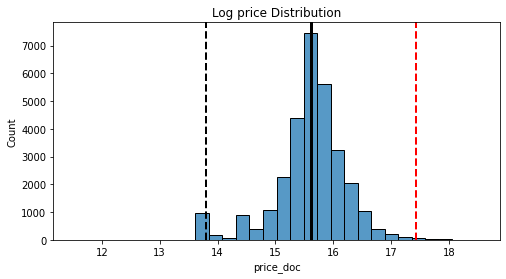

In [30]:
# Постройте гистограмму для признака price_doc в логарифмическом масштабе.
# А также, добавьте на график линии, отображающие среднее и границы интервала для метода трех сигм.

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)
histplot.axvline(log_price_doc.mean(), color='k', lw=3)
histplot.axvline(log_price_doc.mean()+ 3 * log_price_doc.std(), color='r', ls='--', lw=2)
histplot.axvline(log_price_doc.mean()- 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Log price Distribution');

# Число наблюдений, не попавших в интервал слева, меньше чем справа.


In [33]:
# Найдите потенциальные выбросы с помощью метода z-отклонения. Используйте логарифмический масштаб распределения.
# Сделайте «послабление» на 0.7 сигм в в обе стороны распределения. Сколько выбросов вы получили?

outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', True, 3.7, 3.7)
print('Outliers by Z method: {}'.format(outliers.shape[0]))
print('The resulting number of records: {}'.format(cleaned.shape[0]))

Outliers by Z method: 52
The resulting number of records: 30419


In [37]:
# Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod().
# Добавьте в неё параметр log_scale. Если он выставлен в True, то производится
# логарифмирование признака. Примените полученную функцию к признаку price_doc.
# Число межквартильных размахов в обе стороны обозначьте как 3. Чему равно число выбросов, полученных таким методом?

def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale==False:
        x = data[feature]
    else:
        x = np.log(data[feature])
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned    

outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', 3, 3, True)
print('Outliers by Tukeys method: {}'.format(outliers.shape[0]))
print('The resulting number of records: {}'.format(cleaned.shape[0]))

Outliers by Tukeys method: 92
The resulting number of records: 30379
